## Analyzing Buscar Rankings Across Different Mechanisms of Action (MoAs)

This notebook explores how Buscar ranks treatments according to their mechanisms of action (MoA). The main objective is to determine whether treatments sharing the same MoA are consistently ranked lower (i.e., better), reflecting similar phenotypic responses.

We assess Buscar's performance by calculating precision and recall for each MoA, and visualizing the results with waterfall plots. Ideally, treatments with the same MoA should have relatively low Buscar scores, indicating strong similarity in their biological effects.

In [1]:
import sys
import pathlib
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import average_precision_score, precision_recall_curve

sys.path.append("../../")
from utils.io_utils import load_configs

Setting input and output directories

In [2]:
# setting directories
data_dir = pathlib.Path("../0.download-data/data/sc-profiles/").resolve(strict=True)
results_module_dir = pathlib.Path("./results").resolve(strict=True)


# setting cpjump1_dataset
cpjump1_profiles_path = (
    data_dir / "cpjump1/cpjump1_compound_concat_profiles.parquet"
).resolve(strict=True)

cpjump1_moa_rankings = (
    results_module_dir / "moa_analysis/cpjump1_buscar_scores.json"
).resolve(strict=True)

# get experimental dataset
cpjump1_experimental_metadata_path = (
    data_dir / "cpjump1/CPJUMP1-experimental-metadata.csv"
).resolve(strict=True)

# get shared feature space
shared_feature_space = (
    data_dir / "cpjump1/feature_selected_sc_qc_features.json"
).resolve(strict=True)

# moa config
cpjump1_compounds_moa = (data_dir / "cpjump1/cpjump1_compound_moa.tsv").resolve(
    strict=True
)

# set cluster labels dirctory
u2os_cluster_labels_path = (
    results_module_dir / "clusters/cpjump1_u2os_clusters.parquet"
).resolve(strict=True)

# create a plot directory
plot_dir = pathlib.Path("./plots").resolve()
plot_dir.mkdir(exist_ok=True)

# create MoA analysis output directory
moa_analysis_output_dir = (plot_dir / "moa_analysis").resolve()
moa_analysis_output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# load moa annotations
cpjump1_moa_df = pl.read_csv(cpjump1_compounds_moa, separator="\t")

# for the null under th "Metadata_moa" replace it with unknown
cpjump1_moa_df = cpjump1_moa_df.with_columns(
    pl.col("Metadata_moa").fill_null("unknown")
)

# make a dictioanry using the metadata_pert_iname and the Metadata_moa
moa_dict = dict(
    zip(cpjump1_moa_df["Metadata_pert_iname"], cpjump1_moa_df["Metadata_moa"])
)
moa_dict

# loading rankings
moa_rankings = load_configs(cpjump1_moa_rankings)

# Formatting rankings 

Formatting dataset by calculating the mean buscar score for each treatment across all iterations.

In [ ]:
# Extract original and shuffled scores
original_scores = moa_rankings["original"]
shuffled_scores = moa_rankings["shuffled"]

# Create a list to store all rows
rows = []

# Loop through each reference compound
for ref_compound, iterations_data in original_scores.items():
    # Get the MoA for this reference compound
    ref_moa = moa_dict[ref_compound]

    # Loop through each iteration
    for iteration_key, iteration_data in iterations_data.items():
        # Get compound scores for this iteration
        compound_scores = iteration_data.get("compound_scores", {})

        # Loop through each tested compound in this iteration
        for tested_compound, score in compound_scores.items():
            # Get shuffled score for the same combination
            shuffled_score = (
                shuffled_scores.get(ref_compound, {})
                .get(iteration_key, {})
                .get("compound_scores", {})
                .get(tested_compound, None)
            )

            rows.append(
                {
                    "reference_compound": ref_compound,
                    "reference_moa": ref_moa,
                    "tested_compound": tested_compound,
                    "tested_compound_moa": moa_dict.get(tested_compound, "N/A"),
                    "iteration": iteration_key,
                    "compound_score": score,
                    "shuffled_score": shuffled_score
                    if shuffled_score is not None
                    else np.nan,
                }
            )

# Create dataframe from rows
original_scores_df = pl.DataFrame(rows)

# Calculate mean scores including shuffled scores
moa_mean_buscar_scores = original_scores_df.group_by(
    ["reference_moa", "tested_compound", "tested_compound_moa"]
).agg(
    pl.col("compound_score").mean().alias("mean_score"),
    pl.col("compound_score").std().alias("std_score"),
    (pl.col("compound_score").std() / pl.len().sqrt()).alias("se_score"),
    pl.col("shuffled_score").mean().alias("mean_shuffled_score"),
    pl.col("shuffled_score").std().alias("std_shuffled_score"),
)

moa_mean_buscar_scores

shape: (1_406, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬──────────┬───────────┬───────────┐
│ reference_ ┆ tested_com ┆ tested_com ┆ mean_score ┆ std_score ┆ se_score ┆ mean_shuf ┆ std_shuff │
│ moa        ┆ pound      ┆ pound_moa  ┆ ---        ┆ ---       ┆ ---      ┆ fled_scor ┆ led_score │
│ ---        ┆ ---        ┆ ---        ┆ f64        ┆ f64       ┆ f64      ┆ e         ┆ ---       │
│ str        ┆ str        ┆ str        ┆            ┆           ┆          ┆ ---       ┆ f64       │
│            ┆            ┆            ┆            ┆           ┆          ┆ f64       ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪═══════════╪═══════════╡
│ histone    ┆ felodipine ┆ calcium    ┆ 38.446943  ┆ 12.338683 ┆ 3.185834 ┆ 0.0       ┆ 0.0       │
│ lysine met ┆            ┆ channel    ┆            ┆           ┆          ┆           ┆           │
│ hyltransfe ┆            ┆ blocker    ┆            ┆           ┆          ┆           ┆           │
│ ra…        ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ unknown    ┆ nilvadipin ┆ calcium    ┆ 23.232684  ┆ 0.2486    ┆ 0.045388 ┆ 0.0       ┆ 0.0       │
│            ┆ e          ┆ channel    ┆            ┆           ┆          ┆           ┆           │
│            ┆            ┆ blocker    ┆            ┆           ┆          ┆           ┆           │
│ cyclooxyge ┆ 1-octanol  ┆ unknown    ┆ 22.493128  ┆ 0.518993  ┆ 0.11605  ┆ 0.0       ┆ 0.0       │
│ nase       ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ inhibitor  ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ calcium    ┆ bufexamac  ┆ cyclooxyge ┆ 22.913428  ┆ 0.722166  ┆ 0.122068 ┆ 0.987415  ┆ 4.069455  │
│ channel    ┆            ┆ nase       ┆            ┆           ┆          ┆           ┆           │
│ blocker    ┆            ┆ inhibitor  ┆            ┆           ┆          ┆           ┆           │
│ CDK        ┆ triamteren ┆ sodium     ┆ 26.030087  ┆ 3.134536  ┆ 0.626907 ┆ 2.77686   ┆ 6.493786  │
│ inhibitor  ┆ e          ┆ channel    ┆            ┆           ┆          ┆           ┆           │
│            ┆            ┆ blocker    ┆            ┆           ┆          ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …          ┆ …         ┆ …        ┆ …         ┆ …         │
│ phosphodie ┆ puromycin  ┆ protein    ┆ 70.164269  ┆ 0.786154  ┆ 0.175789 ┆ 0.0       ┆ 0.0       │
│ sterase    ┆            ┆ synthesis  ┆            ┆           ┆          ┆           ┆           │
│ inhibitor  ┆            ┆ inhibitor  ┆            ┆           ┆          ┆           ┆           │
│ protein    ┆ puromycin  ┆ protein    ┆ 60.588567  ┆ 3.398048  ┆ 1.074557 ┆ 0.0       ┆ 0.0       │
│ synthesis  ┆            ┆ synthesis  ┆            ┆           ┆          ┆           ┆           │
│ inhibitor  ┆            ┆ inhibitor  ┆            ┆           ┆          ┆           ┆           │
│ HSP        ┆ guanidine  ┆ HSP        ┆ 32.9713    ┆ 1.504734  ┆ 0.388521 ┆ 0.0       ┆ 0.0       │
│ inhibitor  ┆            ┆ inhibitor  ┆            ┆           ┆          ┆           ┆           │
│ potassium  ┆ ganetespib ┆ HSP        ┆ 52.545325  ┆ 0.417172  ┆ 0.107713 ┆ 1.259061  ┆ 4.876323  │
│ channel    ┆            ┆ inhibitor  ┆            ┆           ┆          ┆           ┆           │
│ blocker    ┆            ┆            ┆            ┆           ┆          ┆           ┆           │
│ protein    ┆ felodipine ┆ calcium    ┆ 39.304749  ┆ 14.854577 ┆ 3.835435 ┆ 0.0       ┆ 0.0       │
│ synthesis  ┆            ┆ channel    ┆            ┆           ┆          ┆           ┆           │
│ inhibitor  ┆            ┆ blocker    ┆            ┆           ┆          ┆           ┆           │
└────────────┴────────────┴────────────┴────────────┴───────────┴──────────┴───────────┴───────────┘

## Precision-Recall Curves per MoA (Original vs Shuffled)

In this section we are plotting the precision and recall scores of bucsar rranking of compounds. 

In [5]:
# Prepare data for PR curves per MoA
pr_curves_data = []

# Get unique MoAs
unique_moas = moa_mean_buscar_scores["reference_moa"].unique().to_list()

for moa in unique_moas:
    # Filter data for this reference MoA
    moa_data = moa_mean_buscar_scores.filter(pl.col("reference_moa") == moa)

    # Sort by original mean_score in descending order
    moa_data_original = moa_data.sort("mean_score", descending=True)

    # Sort by shuffled mean_score in descending order
    moa_data_shuffled = moa_data.sort("mean_shuffled_score", descending=True)

    # Create binary labels: 1 if tested compound has same MoA, 0 otherwise
    y_true = (moa_data_original["tested_compound_moa"] == moa).to_numpy().astype(int)

    # Get scores
    y_scores_original = moa_data_original["mean_score"].to_numpy()
    y_scores_shuffled = moa_data_shuffled["mean_shuffled_score"].to_numpy()

    # Calculate precision-recall curves only if there are positive samples
    if y_true.sum() > 0:
        # Original scores
        precision_orig, recall_orig, _ = precision_recall_curve(
            y_true, y_scores_original
        )
        ap_orig = average_precision_score(y_true, y_scores_original)

        # Shuffled scores - need to recalculate y_true for shuffled ordering
        y_true_shuffled = (
            (moa_data_shuffled["tested_compound_moa"] == moa).to_numpy().astype(int)
        )
        precision_shuf, recall_shuf, _ = precision_recall_curve(
            y_true_shuffled, y_scores_shuffled
        )
        ap_shuf = average_precision_score(y_true_shuffled, y_scores_shuffled)

        pr_curves_data.append(
            {
                "moa": moa,
                "precision_orig": precision_orig,
                "recall_orig": recall_orig,
                "ap_orig": ap_orig,
                "precision_shuf": precision_shuf,
                "recall_shuf": recall_shuf,
                "ap_shuf": ap_shuf,
                "n_positive": y_true.sum(),
                "n_total": len(y_true),
            }
        )

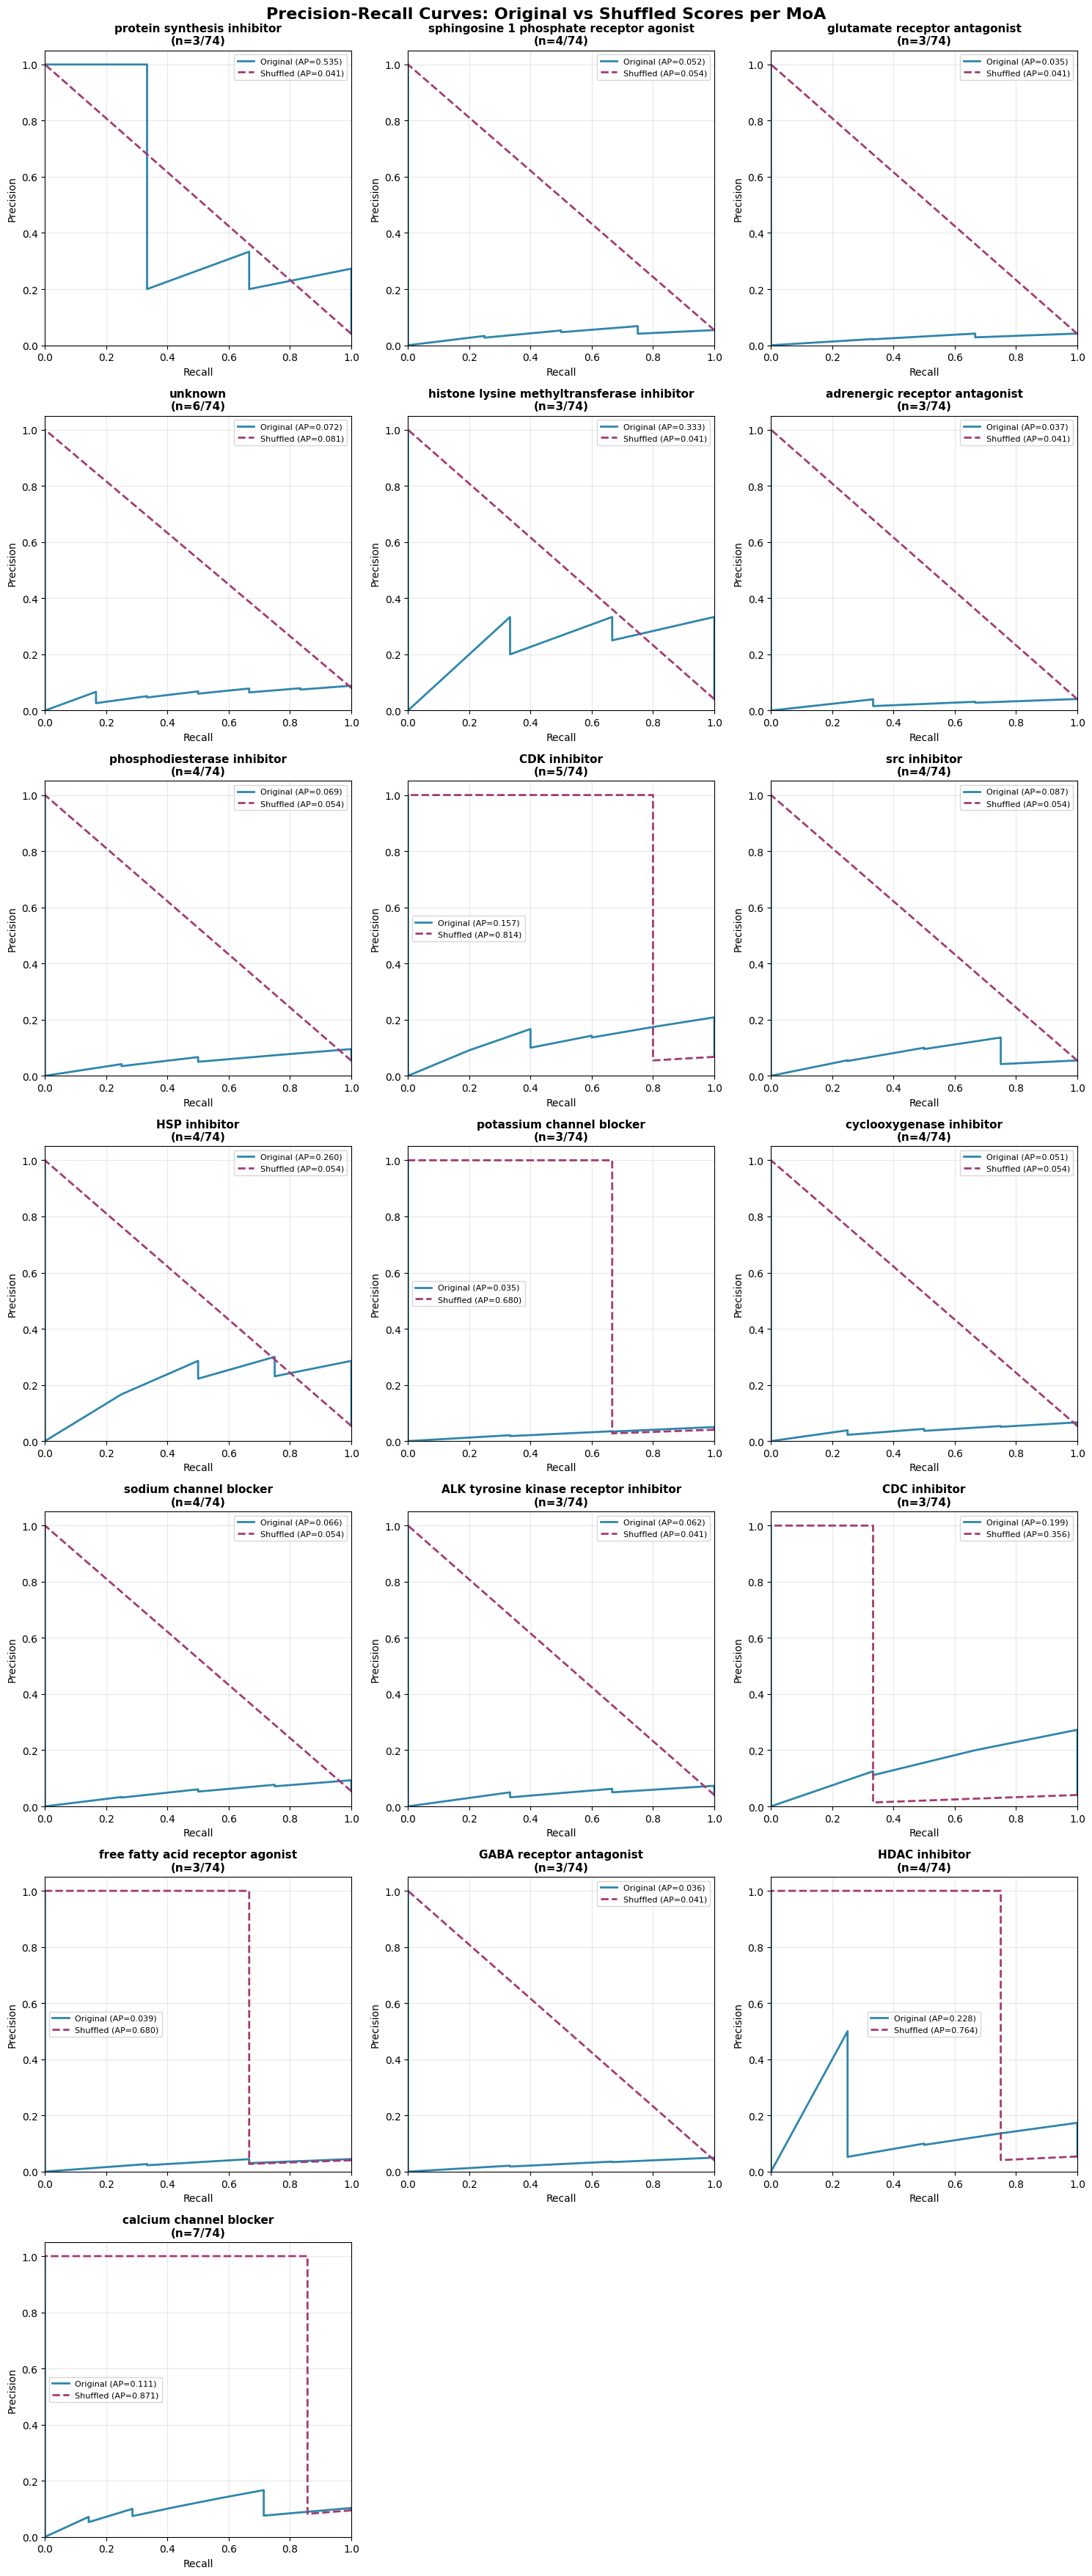

In [6]:
# Create faceted PR curve plot
n_moas = len(pr_curves_data)
n_cols = 3
n_rows = int(np.ceil(n_moas / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_moas > 1 else [axes]

for idx, data in enumerate(pr_curves_data):
    ax = axes[idx]

    # Plot original curve
    ax.plot(
        data["recall_orig"],
        data["precision_orig"],
        label=f"Original (AP={data['ap_orig']:.3f})",
        linewidth=2,
        color="#2E86AB",
    )

    # Plot shuffled curve
    ax.plot(
        data["recall_shuf"],
        data["precision_shuf"],
        label=f"Shuffled (AP={data['ap_shuf']:.3f})",
        linewidth=2,
        color="#A23B72",
        linestyle="--",
    )

    # Set axis and labels
    ax.set_xlabel("Recall", fontsize=10)
    ax.set_ylabel("Precision", fontsize=10)
    ax.set_title(
        f"{data['moa']}\n(n={data['n_positive']}/{data['n_total']})",
        fontsize=11,
        fontweight="bold",
    )
    ax.legend(fontsize=8, loc="best")
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

# Hide unused subplots
for idx in range(n_moas, len(axes)):
    axes[idx].axis("off")

# Final layout adjustments
plt.tight_layout()
plt.suptitle(
    "Precision-Recall Curves: Original vs Shuffled Scores per MoA",
    fontsize=16,
    fontweight="bold",
    y=1.002,
)

# Save
plt.savefig(
    plot_dir / "pr_curves_original_vs_shuffled.png", dpi=400, bbox_inches="tight"
)


# Display plot
plt.show()

## Waterfall Plots: Buscar Scores per Treatment for Each MoA

We will now create waterfall plots to visualize how the buscar scores rank compounds for each mechanism of action (MoA). For a given MoA (e.g., sodium channel blocker), compounds sharing that MoA should ideally have lower buscar scores (appearing further to the left in the plot), indicating stronger similarity to the reference. This visualization helps assess whether compounds with the same MoA are ranked more favorably by the buscar scoring method.

In [7]:
# Set plot parameters
plt.rcParams.update(
    {
        "font.size": 9,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "legend.fontsize": 8,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "axes.linewidth": 1.0,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.major.size": 3.5,
        "ytick.major.size": 3.5,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
    }
)

# Define publication-quality colors
color_matching = "#D62728"  # Red for matching MoA
color_different = "#1F77B4"  # Blue for different MoA
color_grid = "#E0E0E0"  # Light gray for grid

# Setting plot layout
n_moas = len(unique_moas)
n_cols = 3
n_rows = int(np.ceil(n_moas / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_moas > 1 else [axes]

# Iterating per MoA to create waterfall plots
for idx, moa in enumerate(unique_moas):
    ax = axes[idx]

    # Filter data for this reference MoA
    moa_data = moa_mean_buscar_scores.filter(pl.col("reference_moa") == moa)

    # Sort by mean_score in ASCENDING order (lowest scores on left, as lower is better)
    moa_data = moa_data.sort("mean_score", descending=False)

    # Extract data for plotting
    treatments = moa_data["tested_compound"].to_list()
    scores = moa_data["mean_score"].to_numpy()
    errors = moa_data["se_score"].to_numpy()
    treatment_moas = moa_data["tested_compound_moa"].to_list()

    # Determine colors: red if matching MoA, blue otherwise
    colors = [
        color_matching if t_moa == moa else color_different for t_moa in treatment_moas
    ]

    # Create bar plot
    x_pos = np.arange(len(treatments))
    bars = ax.bar(
        x_pos,
        scores,
        color=colors,
        alpha=0.85,
        edgecolor="white",
        linewidth=0.4,
        width=0.9,
    )

    # Add error bars with publication quality
    ax.errorbar(
        x_pos,
        scores,
        yerr=errors,
        fmt="none",
        ecolor="black",
        capsize=2.5,
        capthick=0.9,
        elinewidth=0.9,
        alpha=0.75,
        zorder=3,
    )

    # Formatting with publication quality
    ax.set_xlabel("Treatment", fontsize=10, fontweight="normal")
    ax.set_ylabel("Buscar Score", fontsize=10, fontweight="normal")
    ax.set_title(
        f"{moa}\n(n={len(treatments)} treatments)",
        fontsize=11,
        fontweight="bold",
        pad=8,
    )
    ax.set_xticks(x_pos)
    ax.set_xticklabels(treatments, rotation=90, ha="center", va="top", fontsize=7.5)

    # Grid styling
    ax.grid(
        axis="y", alpha=0.3, linewidth=0.6, color=color_grid, linestyle="-", zorder=0
    )
    ax.set_axisbelow(True)

    # Clean spines (publication style)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)

    # Add baseline at y=0
    ax.axhline(y=0, color="black", linewidth=1.0, zorder=1)

    # Set margins
    ax.margins(x=0.01)

    # Add legend only to first subplot
    if idx == 0:
        legend_elements = [
            Patch(
                facecolor=color_matching,
                alpha=0.85,
                edgecolor="white",
                linewidth=0.4,
                label="Matching MoA",
            ),
            Patch(
                facecolor=color_different,
                alpha=0.85,
                edgecolor="white",
                linewidth=0.4,
                label="Different MoA",
            ),
        ]
        ax.legend(
            handles=legend_elements,
            loc="upper left",
            fontsize=8,
            frameon=True,
            fancybox=False,
            edgecolor="black",
            framealpha=1.0,
            borderpad=0.6,
        )

# Hide unused subplots
for idx in range(n_moas, len(axes)):
    axes[idx].axis("off")

# Final layout adjustments
plt.tight_layout(pad=2.5, h_pad=3.5, w_pad=2.5)
plt.suptitle(
    "Waterfall Plots: Buscar Scores per Treatment for Each MoA",
    fontsize=16,
    fontweight="bold",
    y=1.002,
)

# Save high-quality figures
plt.savefig(
    plot_dir / "waterfall_buscar_scores_publication.png",
    dpi=400,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)

plt.show()

# Reset matplotlib parameters to defaults
plt.rcParams.update(plt.rcParamsDefault)

Next is to generate waterfall plot for shuffle data 

In [8]:
# Create publication-quality waterfall plots with SHUFFLED buscar scores per treatment for each MoA

# Set publication-quality parameters
plt.rcParams.update(
    {
        "font.size": 9,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "legend.fontsize": 8,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "axes.linewidth": 1.0,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.major.size": 3.5,
        "ytick.major.size": 3.5,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
    }
)

# Define publication-quality colors
color_matching = "#D62728"  # Red for matching MoA
color_different = "#1F77B4"  # Blue for different MoA
color_grid = "#E0E0E0"  # Light gray for grid

n_moas = len(unique_moas)
n_cols = 3
n_rows = int(np.ceil(n_moas / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_moas > 1 else [axes]

for idx, moa in enumerate(unique_moas):
    ax = axes[idx]

    # Filter data for this reference MoA
    moa_data = moa_mean_buscar_scores.filter(pl.col("reference_moa") == moa)

    # Sort by SHUFFLED mean_score in ASCENDING order (lowest scores on left, as lower is better)
    moa_data = moa_data.sort("mean_shuffled_score", descending=False)

    # Extract data for plotting
    treatments = moa_data["tested_compound"].to_list()
    scores = moa_data["mean_shuffled_score"].to_numpy()
    errors = moa_data["std_shuffled_score"].to_numpy() / np.sqrt(
        len(moa_data)
    )  # Calculate SE for shuffled
    treatment_moas = moa_data["tested_compound_moa"].to_list()

    # Determine colors: red if matching MoA, blue otherwise
    colors = [
        color_matching if t_moa == moa else color_different for t_moa in treatment_moas
    ]

    # Create bar plot
    x_pos = np.arange(len(treatments))
    bars = ax.bar(
        x_pos,
        scores,
        color=colors,
        alpha=0.85,
        edgecolor="white",
        linewidth=0.4,
        width=0.9,
    )

    # Add error bars with publication quality
    ax.errorbar(
        x_pos,
        scores,
        yerr=errors,
        fmt="none",
        ecolor="black",
        capsize=2.5,
        capthick=0.9,
        elinewidth=0.9,
        alpha=0.75,
        zorder=3,
    )

    # Formatting with publication quality
    ax.set_xlabel("Treatment", fontsize=10, fontweight="normal")
    ax.set_ylabel("Shuffled Buscar Score", fontsize=10, fontweight="normal")
    ax.set_title(
        f"{moa}\n(n={len(treatments)} treatments)",
        fontsize=11,
        fontweight="bold",
        pad=8,
    )
    ax.set_xticks(x_pos)
    ax.set_xticklabels(treatments, rotation=90, ha="center", va="top", fontsize=7.5)

    # Grid styling
    ax.grid(
        axis="y", alpha=0.3, linewidth=0.6, color=color_grid, linestyle="-", zorder=0
    )
    ax.set_axisbelow(True)

    # Clean spines (publication style)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)

    # Add baseline at y=0
    ax.axhline(y=0, color="black", linewidth=1.0, zorder=1)

    # Set margins
    ax.margins(x=0.01)

    # Add legend only to first subplot
    if idx == 0:
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(
                facecolor=color_matching,
                alpha=0.85,
                edgecolor="white",
                linewidth=0.4,
                label="Matching MoA",
            ),
            Patch(
                facecolor=color_different,
                alpha=0.85,
                edgecolor="white",
                linewidth=0.4,
                label="Different MoA",
            ),
        ]
        ax.legend(
            handles=legend_elements,
            loc="upper left",
            fontsize=8,
            frameon=True,
            fancybox=False,
            edgecolor="black",
            framealpha=1.0,
            borderpad=0.6,
        )

# Hide unused subplots
for idx in range(n_moas, len(axes)):
    axes[idx].axis("off")

# Final layout adjustments
plt.tight_layout(pad=2.5, h_pad=3.5, w_pad=2.5)
plt.suptitle(
    "Waterfall Plots: Shuffled Buscar Scores per Treatment for Each MoA",
    fontsize=16,
    fontweight="bold",
    y=1.002,
)

# Save high-quality figures
plt.savefig(
    plot_dir / "waterfall_shuffled_buscar_scores_publication.png",
    dpi=400,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
)

plt.show()

# Reset matplotlib parameters to defaults
plt.rcParams.update(plt.rcParamsDefault)